In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score, cross_val_predict

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from joblib import dump
from joblib import load

In [29]:
def get_transformer_feature_names(columnTransformer):

    output_features = []

    for name, pipe, features in columnTransformer.transformers_:
        if name!='remainder':
            for i in pipe:
                if hasattr(i,'categories_'):
                    output_features.extend(i.get_feature_names_out(features))
                else:
                    output_features.extend(features)
    return output_features

In [30]:
df_main_com = pd.read_pickle('df_main.pkl')
df_main = df_main_com.head(5000)
df_main.shape
pd.set_option('display.max_columns', None)
df_main.head()

,body_id,assembly_id,name,volume,area,material_category,properties_vertex_count,properties_edge_count,properties_face_count,properties_loop_count,properties_shell_count,properties_body_count,properties_area,properties_volume,properties_likes_count,properties_comments_count,properties_views_count,properties_category_Mechanical Engineering,properties_category_Product Design,properties_category_Miscellaneous,properties_category_Electronics,properties_category_Machine design,properties_category_Furniture + Household,properties_category_Tools,properties_category_Automotive,properties_category_Design,properties_category_Toys,properties_industry_Other Industries,"properties_industry_Architecture, Engineering & Construction",properties_industry_Media & Entertainment,properties_industry_Civil Infrastructure,properties_industry_Product Design & Manufacturing,components_name
0,0b40d208-0529-11ec-b1f1-020dc2b44123,100221_4d7b66c4,NaN,1.183269,13.793986,Metal_Ferrous_Steel,1065,1686,690,759,20,20,2435.96399,422.013372,0,0,263,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,Hinge
1,0b41206c-0529-11ec-87d0-020dc2b44123,100221_4d7b66c4,NaN,188.236351,1194.122208,Plastic,1065,1686,690,759,20,20,2435.96399,422.013372,0,0,263,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,Base
2,0b419630-0529-11ec-a6a6-020dc2b44123,100221_4d7b66c4,NaN,112.561776,737.410188,Plastic,1065,1686,690,759,20,20,2435.96399,422.013372,0,0,263,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,Lid
3,0b420ad4-0529-11ec-aac9-020dc2b44123,100221_4d7b66c4,NaN,1.646435,41.360040,Plastic,1065,1686,690,759,20,20,2435.96399,422.013372,0,0,263,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,NaN
4,0b427fe4-0529-11ec-ba06-020dc2b44123,100221_4d7b66c4,NaN,0.094115,2.612833,Metal_Ferrous_Steel,1065,1686,690,759,20,20,2435.96399,422.013372,0,0,263,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,01-1785


In [31]:
df_main.drop(['body_id', 'assembly_id','name','components_name'], axis=1)

,volume,area,material_category,properties_vertex_count,properties_edge_count,properties_face_count,properties_loop_count,properties_shell_count,properties_body_count,properties_area,properties_volume,properties_likes_count,properties_comments_count,properties_views_count,properties_category_Mechanical Engineering,properties_category_Product Design,properties_category_Miscellaneous,properties_category_Electronics,properties_category_Machine design,properties_category_Furniture + Household,properties_category_Tools,properties_category_Automotive,properties_category_Design,properties_category_Toys,properties_industry_Other Industries,"properties_industry_Architecture, Engineering & Construction",properties_industry_Media & Entertainment,properties_industry_Civil Infrastructure,properties_industry_Product Design & Manufacturing
0,1.183269,13.793986,Metal_Ferrous_Steel,1065,1686,690,759,20,20,2435.963990,422.013372,0,0,263,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1
1,188.236351,1194.122208,Plastic,1065,1686,690,759,20,20,2435.963990,422.013372,0,0,263,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1
2,112.561776,737.410188,Plastic,1065,1686,690,759,20,20,2435.963990,422.013372,0,0,263,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1
3,1.646435,41.360040,Plastic,1065,1686,690,759,20,20,2435.963990,422.013372,0,0,263,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1
4,0.094115,2.612833,Metal_Ferrous_Steel,1065,1686,690,759,20,20,2435.963990,422.013372,0,0,263,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.904779,4.523893,Metal_Ferrous_Steel,6516,9840,3798,4398,36,36,1403.813566,218.768078,0,0,342,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4996,0.227858,3.686711,Metal_Ferrous_Steel,6516,9840,3798,4398,36,36,1403.813566,218.768078,0,0,342,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4997,0.071396,3.916891,Metal_Ferrous_Steel,6516,9840,3798,4398,36,36,1403.813566,218.768078,0,0,342,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4998,0.071396,3.916891,Metal_Ferrous_Steel,6516,9840,3798,4398,36,36,1403.813566,218.768078,0,0,342,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [32]:
from sklearn.model_selection import train_test_split

X = df_main.drop(columns=['material_category'])
y = df_main['material_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
# Define preprocessors
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

In [34]:
# List of classifiers
classifiers = [
    ("Logistic Regression", LogisticRegression(max_iter=5000, random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42)),
    ("LGBM", LGBMClassifier(random_state=42))
    #("Gradient Boosting", GradientBoostingClassifier(random_state=42)),
    #("SVC", SVC(random_state=42))
]

In [35]:
metrics = {
    'accuracy': accuracy_score,
    'precision': lambda y_true, y_pred: precision_score(y_true, y_pred, average='weighted'),
    'recall': lambda y_true, y_pred: recall_score(y_true, y_pred, average='weighted'),
    'f1': lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted')
}

results = {metric: [] for metric in metrics.keys()}

In [36]:
for name, clf in tqdm(classifiers, desc="Testing Models"):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    pipeline.fit(X_train, y_train)  # Fitting the model

    dump(pipeline, f"{name.replace(' ', '_').lower()}_model.pkl")  # Saving the model
    
    y_pred = cross_val_predict(pipeline, X, y, cv=3)
    
    for metric_name, metric_func in metrics.items():
        score = metric_func(y, y_pred)
        results[metric_name].append(score)

Testing Models: 100%|██████████| 3/3 [00:18<00:00,  6.13s/it]


In [37]:
classifier_names = [name for name, _ in classifiers]
df_results = pd.DataFrame(results, index=classifier_names)
print(df_results)

                     accuracy  precision  recall        f1
Logistic Regression    0.3184   0.269364  0.3184  0.286777
Random Forest          0.2688   0.268875  0.2688  0.268600
LGBM                   0.2844   0.283514  0.2844  0.283268


In [38]:
loaded_model = load("logistic_regression_model.pkl")

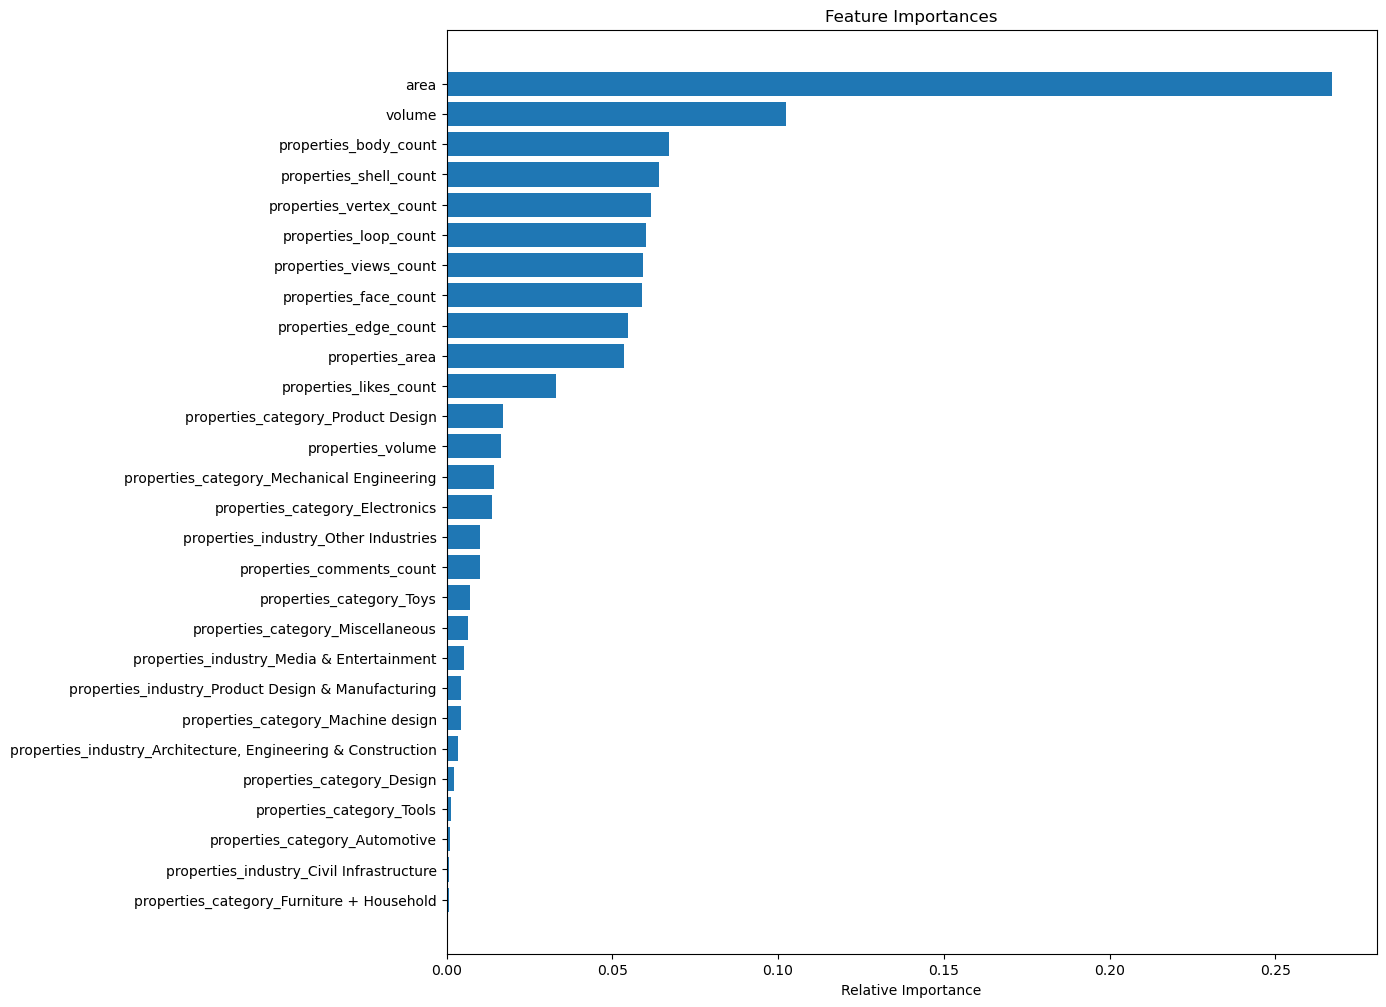

In [39]:
# Feature importances plotting (example for Random Forest)
loaded_model = load("random_forest_model.pkl")
clf = loaded_model.named_steps['classifier']
if hasattr(clf, 'feature_importances_'):
    importances = clf.feature_importances_
    indices = np.argsort(importances)
    feature_names = get_transformer_feature_names(preprocessor)
    plt.figure(figsize=(12, 12))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()